# Kickstarter Startup Analysis

1. How should we design our Kickstarter campaign in order to make our startup funding phase as succesful as possible?
    - **Categorie** (Assumption Tech) - Succesful campaigns
        -> ratio succesful/unsuccesful/live definieren
        -> one-sample 1 tegenover het totaal
        -> two sample 1 tegenover de rest, of Tech vs Design
    - **US vs NL** (Assumption: Silicon Valley vs. the Netherlands)
        -> Average pledged amount in NL hoger OF lager dan in US (1 of 2 sample T test)
    - **Number of backers** (Assumption: popularity of campaign defines popularity of startup)
        -> Ga je voor weinig backers met veel of veel backers met weinig -> verschil in succesful (Hoeveel backers per in je goal)
    -> Zoja/Zonee -> define confidence intervals voor backers voor ons "start-up" plan
    
    - **Pledge amount asked** - Pledged (goal - converted)
    
2. Which pledge amount will lead to the highest possible funding?

3. How could the location of the kickstarter campaign, or the sub-category, influence the success rate of our kickstarter campaign?

**To do**  
~~Elske: Fix git issues  ~~  
Rianne: #Drop duplicates (per project_id, check categorieen - 1, 2 en 3 -- zijn hetzelfde, dus sort_values by pledged amount, keepfirst)  
Rianne: #Currency -> use usd_pledged -> convert_amount can be dropped, fx_rate also, currency also   
Rianne: #Take out live  
~~Elske:  #Canceled and unsuccesful -> Failed~~  
~~Elske:  #Unfold Dict "location" unfold: 'name', 'expanded_country'~~  
~~Elske:  #Create column with average pledge per backer  ~~  
Both: Check for missing values and how to solve them + add code for hypothesis testing

In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import json
from datetime import datetime
import scipy.stats as stats
from scipy.stats import norm

Download the file <a href="https://drive.google.com/drive/folders/1hIBnfoXrXNW2vF_ka8R8Y0mltCmBjqPZ" target="_blank">here</a>.

In [2]:
pip install fonts

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install font-amatic-sc

Note: you may need to restart the kernel to use updated packages.


In [4]:
from PIL import ImageFont
from fonts.ttf import AmaticSC

In [5]:
font = ImageFont.truetype(AmaticSC)

In [6]:
#Importing the data using a relative path
#Mac
df = pd.read_csv('../Kickstarter_analysis/sep2020.csv', converters={'category': eval})
df.head()

#Windows
#df = pd.read_csv('data\\sep2020.csv')
#df.head()

,backers_count,blurb,converted_pledged_amount,country,created_at,currency,deadline,fx_rate,goal,id,...,pledged,spotlight,state,state_changed_at,usd_pledged,category_id,category_name,category_parent_id,category_parent_name,project_id
0,61,Support great art! Join us as we re-stage the ...,4618,US,1579292017,USD,1583025192,1.0,3000.0,1568973024,...,4618.0,True,successful,1583025192,4618.0,254,Performances,6.0,Dance,3914215
1,52,JinBucha is a new kind of Brewery in North Par...,3461,US,1446051515,USD,1450118057,1.0,20000.0,1782378629,...,3461.0,False,failed,1450118057,3461.0,307,Drinks,10.0,Food,2198010
2,0,"""Taste The Scent of Tea"" Rose and Blanc Tea Ro...",0,US,1518159717,USD,1520233260,1.0,15000.0,2076142479,...,0.0,False,failed,1520233260,0.0,307,Drinks,10.0,Food,3304826
3,2,Bringing Philly cheesesteaks (and other delici...,25,US,1454217596,USD,1459885844,1.0,2000.0,1416797221,...,25.0,False,failed,1459885844,25.0,311,Food Trucks,10.0,Food,2349147
4,150,a frog plushie keychain and frog butt pin for ...,3275,US,1571342290,USD,1574445600,1.0,800.0,1708708142,...,3275.0,True,successful,1574445600,3275.0,28,Product Design,7.0,Design,3834865


**Step 1:** Data Cleaning and Wrangling
- Transforming unix time stamps to datetime

In [7]:
# Dates transformed [['created_at'], ['deadline'], ['launched_at'], ['state_changed_at']]
df[['created_at','deadline', 'launched_at', 'state_changed_at']].apply(pd.to_datetime, unit='s')

,created_at,deadline,launched_at,state_changed_at
0,2020-01-17 20:13:37,2020-03-01 01:13:12,2020-01-31 01:13:12,2020-03-01 01:13:12
1,2015-10-28 16:58:35,2015-12-14 18:34:17,2015-11-14 18:34:17,2015-12-14 18:34:17
2,2018-02-09 07:01:57,2018-03-05 07:01:00,2018-02-09 20:41:27,2018-03-05 07:01:00
3,2016-01-31 05:19:56,2016-04-05 19:50:44,2016-02-05 20:50:44,2016-04-05 19:50:44
4,2019-10-17 19:58:10,2019-11-22 18:00:00,2019-11-08 18:00:00,2019-11-22 18:00:00
...,...,...,...,...
219683,2019-02-21 18:33:41,2019-03-29 21:00:00,2019-02-27 15:12:10,2019-03-29 21:00:02
219684,2013-03-05 20:13:03,2013-08-10 07:45:40,2013-07-05 07:45:40,2013-08-10 07:45:40
219685,2016-06-21 00:35:01,2016-08-13 21:49:58,2016-07-14 21:49:58,2016-08-13 21:49:58
219686,2015-11-28 19:14:15,2016-01-09 19:19:33,2015-12-10 19:19:33,2016-01-09 19:19:34


- Remove live kickstarter campaings.

In [8]:
# Drop records of unfinished project (category live)
df = df.loc[df['state'] != 'live']
len(df)

# Check if records are dropped
df['state'].value_counts()

#Value_counts shows there are both canceled and failed campaigns. Categorize into successfull and unsuccessful
df['state_cat'] = np.where(df['state']=='successful', 'successful', 'unsuccessful')
df['state_cat'].value_counts()

#Create one data set with only successful campaigns
df = df.loc[df['state'] == 'successful']

#Keep dataset with all categories
#df_all = 


- Drop duplicated projects

In [9]:
# Print number of records
print('number of records: ', len(df))

# sort by highest pledged and drop duplicated project ids
df = df.sort_values(by='usd_pledged',ascending=False).drop_duplicates(subset='project_id', keep='first')

# check number of records
print('number of records after dropping duplicated project ids: ', len(df))

number of records:  128156
number of records after dropping duplicated project ids:  104210


- Classify cancelled and unsuccesful as both "unsuccesful"  
Since we are looking to launch a succesful campaign for our start-up, 
we categorize the data in two categories: "Succesful" and "Failed" (compromising canceled and failed campaings).

- Create variable 'average_pledge' per backer

In [10]:
df['average_pledge'] = (df['usd_pledged']/df['backers_count'])

- Check for missing values

In [11]:
#checking for missing values
df.isna().sum()

backers_count                  0
blurb                          0
converted_pledged_amount       0
country                        0
created_at                     0
currency                       0
deadline                       0
fx_rate                        0
goal                           0
id                             0
launched_at                    0
location                     157
name                           0
pledged                        0
spotlight                      0
state                          0
state_changed_at               0
usd_pledged                    0
category_id                    0
category_name                  0
category_parent_id          7557
category_parent_name        7557
project_id                     0
state_cat                      0
average_pledge                 0
dtype: int64

In [12]:
#replacing missing parent category name with their category name
df['category_parent_name'] = np.where(df['category_parent_name'].isnull(), df['category_name'], df['category_parent_name'])

In [13]:
#16009 missing values for average_pledge is explained by 16009 entries with a backers count of 0.
df.loc[df['backers_count'] == 0].count()

backers_count               0
blurb                       0
converted_pledged_amount    0
country                     0
created_at                  0
currency                    0
deadline                    0
fx_rate                     0
goal                        0
id                          0
launched_at                 0
location                    0
name                        0
pledged                     0
spotlight                   0
state                       0
state_changed_at            0
usd_pledged                 0
category_id                 0
category_name               0
category_parent_id          0
category_parent_name        0
project_id                  0
state_cat                   0
average_pledge              0
dtype: int64

# Data Exploration

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

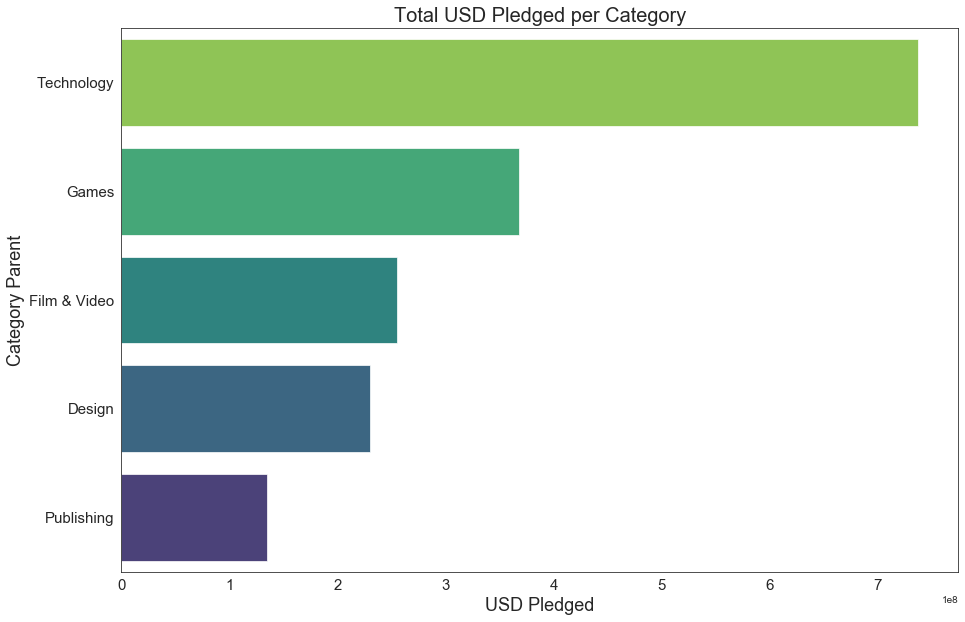

In [58]:
#Grouping the df by main category, sorted by sum of converted_pledged amount.
top_pledged = df.loc[df['state'] == 'successful'].groupby(['category_parent_name']).sum().reset_index().sort_values(by='usd_pledged', ascending=False)
top_backers = df.groupby(['category_parent_name']).sum().reset_index().sort_values(by='backers_count', ascending=False)

#Selecting top five from top_pledged and top_backers
top_five_pledged = top_pledged.head(5)
top_five_backers = top_backers.head(5)
pal_pled = sns.color_palette("viridis", len(top_five_pledged))
pal_back = sns.color_palette("viridis", len(top_five_backers))
rank_pled = top_five_pledged["usd_pledged"].argsort().argsort()
rank_back = top_five_backers["backers_count"].argsort().argsort()

#Plotting the top five
plt.figure(figsize=(15, 10))
sns.barplot(x='usd_pledged', y='category_parent_name', data=top_five_pledged, linewidth=0.7, palette=np.array(pal_pled[::+1])[rank_pled])
plt.title('Total USD Pledged per Category', fontsize=20)
plt.xlabel('USD Pledged', fontsize=18)
plt.ylabel('Category Parent', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

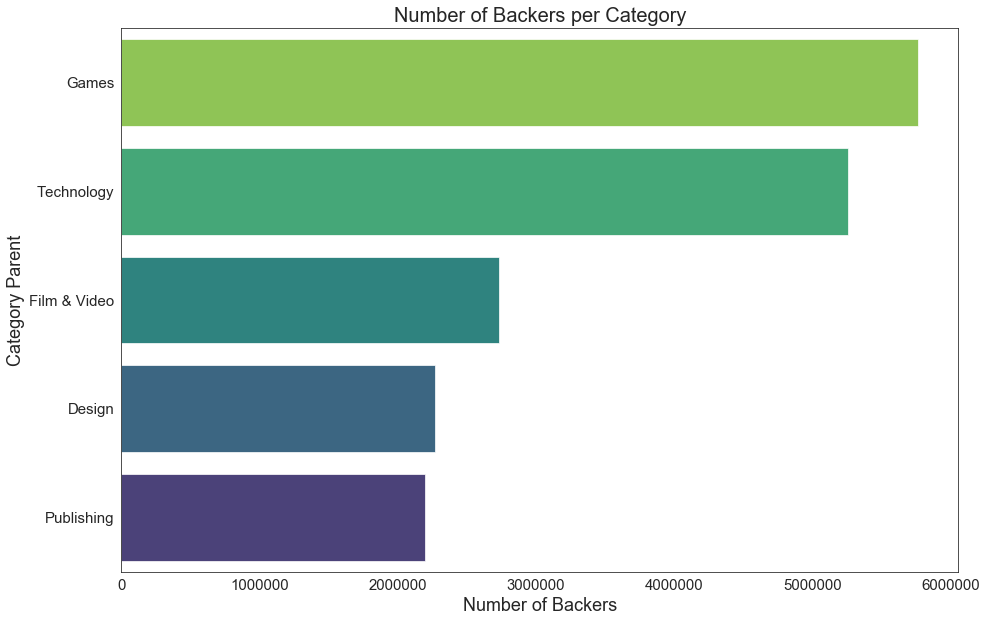

In [60]:
#Plotting the top five number of backers
plt.figure(figsize=(15, 10))
sns.barplot(x='backers_count',y='category_parent_name', data=top_five_backers, linewidth=0.7, palette=np.array(pal_back[::+1])[rank_back])
plt.title('Number of Backers per Category', fontsize=20)
plt.xlabel('Number of Backers', fontsize=18)
plt.ylabel('Category Parent', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

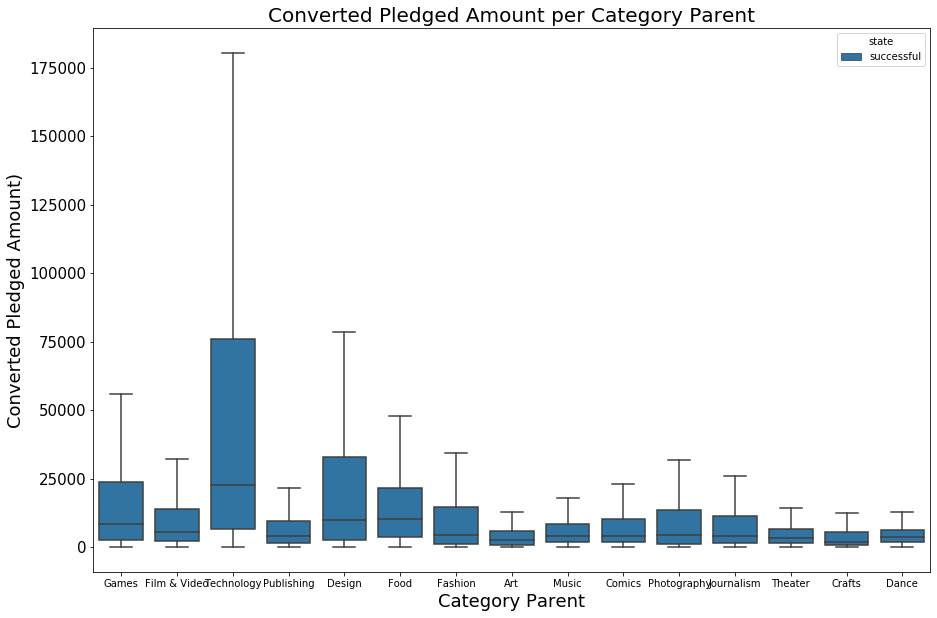

In [16]:
plt.figure(figsize=(15, 10))
sns.boxplot(x='category_parent_name', y='converted_pledged_amount', hue='state', data=df, orient='v', showfliers=False);
plt.title('Converted Pledged Amount per Category Parent', fontsize=20);
plt.xlabel('Category Parent', fontsize=18)
plt.ylabel('Converted Pledged Amount)', fontsize=18)
plt.xticks(fontsize=10)
plt.yticks(fontsize=15);

#Can we use "proportion of the population" - om significant verschil tussen succesful (tech en de rest)


In [17]:
df.groupby(['category_name']).sum().sort_values(by='converted_pledged_amount', ascending=False)

,backers_count,converted_pledged_amount,created_at,deadline,fx_rate,goal,id,launched_at,pledged,spotlight,state_changed_at,usd_pledged,category_id,category_parent_id,project_id,average_pledge
category_name,,,,,,,,,,,,,,,,
Product Design,1836490,195658359,3288888432554,3309783880291,1941.333076,5.246923e+07,2248122705553,3303751295987,4.803735e+08,2094,3309783894289,1.949631e+08,58632,14658.0,8011439673,308564.676186
Hardware,1266524,193251148,2140515829638,2154842727592,1474.768212,6.349782e+07,1561727168670,2150333941228,2.459568e+08,1493,2154842740288,1.932391e+08,77636,23888.0,2673902470,310642.029339
Tabletop Games,2061370,159820464,3279620274948,3296165718794,2108.632625,3.034394e+07,2233736784496,3291858067796,2.148260e+08,2074,3296165773964,1.595537e+08,70516,24888.0,8132985556,107572.879384
Gadgets,1388306,146760385,2304697510561,2318325388300,1414.620798,6.718271e+07,1638225609144,2313520348963,2.612305e+08,1541,2318328679138,1.467420e+08,519317,24656.0,4383817467,219522.230379
Video Games,2559287,131884705,3403568403792,3426732407664,2241.983575,2.658325e+08,2455947403317,3420434257454,1.088081e+09,2278,3426732440955,1.318331e+08,79730,27336.0,6430744358,111495.776507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Farmer's Markets,2475,240260,36396170813,36533849276,22.204281,2.740580e+05,26893002362,36460045707,3.560157e+05,24,36533849350,2.402092e+05,7440,240.0,77651201,2943.938611
Embroidery,4135,232977,65086864778,65252640436,37.725038,7.920000e+05,44351393774,65142567745,1.356260e+06,43,65252640477,2.331293e+05,14878,1118.0,132663966,2085.327088
Quilts,1740,173079,30058915719,30245526723,20.773466,1.289510e+05,20304790997,30194578046,1.782610e+05,21,30245526826,1.735189e+05,7392,546.0,37941940,1733.148783


In [ ]:
#corr
corr = df['converted_pledged_amount'].corr(df['backers_count'])
#set figure size
plt.figure(figsize=(15, 10))
#plot the data
sns.regplot(data=df,x=df['converted_pledged_amount'],y=df['backers_count'], ci=None)
#format the plot
text = 'r=%s' % (corr)
plt.text(1, 19, text, fontsize=14)
plt.title('', fontsize=20);
plt.xlabel('', fontsize=18)
plt.ylabel('', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18);

# Statistical Analysis

In [ ]:
#Confidence Intervals:
# To define between pledge amount x and x we should ask
# To define between number of backers x and x we should aim for

# One-sample
# 1 category opposed to population mean

# Two-sample
#2 categories (tech vs. food) and Netherlands/Europe vs. US

**Categories** (Assumption that Technology startups have highest funding due to popularity/size of investments) 

https://producthype.co/kickstarter-tips-2019/ 

        - Succesful campaigns
        -> ratio succesful/unsuccesful/live definieren
        -> one-sample 1 tegenover het totaal
        -> two sample 1 tegenover de rest, of Tech vs Design 
        
*   H0: $\mu_{1} = \mu_{2}$, There is no difference between total pledge for successful campaigns in the Technology category and all other categories
*   H1: $\mu_{1} \neq \mu_{2},$ There is a difference between total pledge for successful campaigns in the Technology category and all other categories

For this test, we have to groups in which we can not match the rows to eachother, hence **independent samples**.
Secondly, we assume a **normally distributed population**.

(?) We cannot (or do not want to) assume Equal Variances.

In [63]:
#One sample t-test: Technology campaigns against the total campaigns

sample = df[df['category_parent_name'] == 'Technology'] 

# one-tailed, greater than 86000
sample_m = np.mean(sample['usd_pledged'])
m = np.mean(df['usd_pledged'])
print("The mean usd_pledged for the Technology category is", sample_m)
print("The mean usd_pledged for the all categories is", m)

# computing the test statistics
t, p = stats.ttest_1samp(sample['usd_pledged'], m)

alpha = 0.05
if (t > 0) & (p/2 < alpha):
    print("We reject the null hypothesis, the mean is greater than {}", format(m))
else:
    print("accept null hypothesis")

print(t, p)

The mean usd_pledged for the Technology category is 96440.80866514707
The mean usd_pledged for the all categories is 22242.121659483222
We reject the null hypothesis, the mean is greater than {} 22242.121659483222
23.198848001236776 4.105186445616533e-115


(0, 80000)

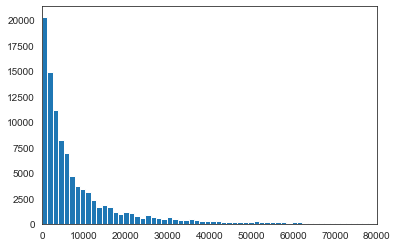

In [42]:
#To Do: plot to prove normally distributed population
plt.hist(x=df['usd_pledged'], bins=10000)
#plt.ticklabel_format(useOffset=False)
plt.xlim(0,80000)
#plt.show()


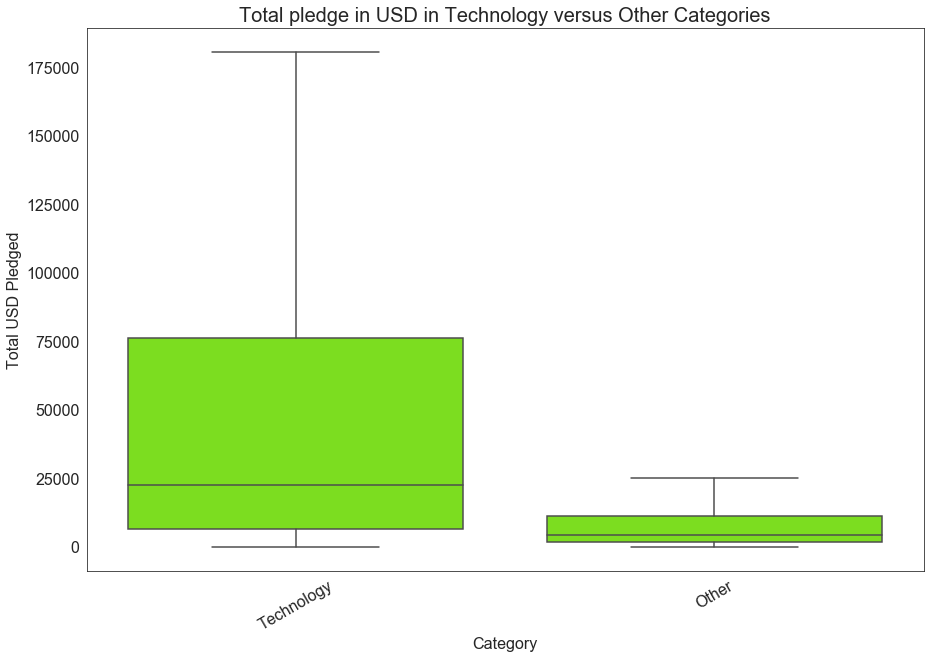

In [19]:
#Compute variables to test
successful_campaigns = df.loc[df['state'] == 'successful']
successful_campaigns_tech = successful_campaigns.loc[successful_campaigns['category_parent_name'] == 'Technology']
successful_campaigns_other = successful_campaigns.loc[successful_campaigns['category_parent_name'] != 'Technology']

#Plot to estimate differences
sns.set_style("white")
successful_campaigns['tech_vs_other'] = np.where(successful_campaigns['category_parent_name']=='Technology', 'Technology', 'Other')
plt.figure(figsize=(15,10))
sns.set_style("white")
sns.boxplot(x="tech_vs_other", y="usd_pledged", data=successful_campaigns, order=["Technology", "Other"], showfliers=False, color="lawngreen")
plt.title('Total pledge in USD in Technology versus Other Categories', fontsize=20)
plt.xlabel('Category', fontsize=16)
plt.ylabel('Total USD Pledged', fontsize=16)
plt.xticks(fontsize=16)
plt.xticks(rotation=30)
plt.yticks(fontsize=16);

In [ ]:
#Plot boxplots versus other five top categories according to count
plt.figure(figsize=(15,10))
sns.set_style("white")
ax = sns.boxplot(x="category_parent_name", y="usd_pledged", data=successful_campaigns, order=["Technology", "Design", "Games", "Food", "Fashion"], showfliers=False, color="lawngreen")

#Lay-out
plt.title('Total pledge in USD in Technology versus Other Categories', fontsize=20)
plt.xlabel('Category', fontsize=16)
plt.ylabel('Total USD Pledged', fontsize=16)
plt.xticks(fontsize=16)
plt.xticks(rotation=30)
plt.yticks(fontsize=16);

In [ ]:
df.groupby(by='category_parent_name').mean()

In [62]:
from scipy.stats import ttest_ind

#Two sample t-test

#Decide whether equal variances are true or false
ttest_ind(successful_campaigns_tech['usd_pledged'], successful_campaigns_other['usd_pledged'], equal_var=False)
ttest_ind(successful_campaigns_tech['usd_pledged'], successful_campaigns_other['usd_pledged'], equal_var=True)

Ttest_indResult(statistic=49.897694591269115, pvalue=0.0)

In [ ]:
#Idea: build a loop two-sample-t-test for testing Technology against Design, Games, Food and Fashion.

# Countries

- US vs NL (Assumption: Silicon Valley vs. the Netherlands)
    - Usd pledged in NL hoger OF lager dan in US (1 of 2 sample T test)  
    -> Dict "location" needs to be unfolded ('name', 'expanded_country')  
    -> Test binnen alle categorien eerst, eventueel later alleen in hierboven gekozen categorie  
Rianne

In [68]:
# Create two samples: one US and one NL 
df_us = df.loc[df['country']=='US']
df_nl = df.loc[df['country']=='NL']
df_usnl = df[((df['country'] == 'US') | (df['country'] == 'NL'))]
print('Number of records US: ', len(df_us))
print('Number of records NL: ', len(df_nl))
print('Number of records Us & NL: ', len(df_usnl))

Number of records US:  74722
Number of records NL:  685
Number of records Us & NL:  75407


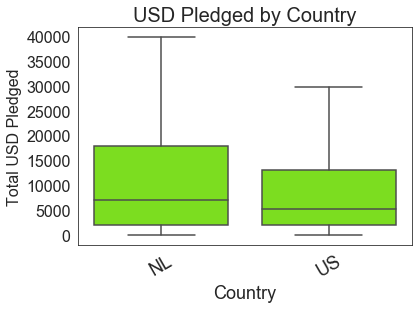

In [69]:
ax = sns.boxplot(x="country", y="usd_pledged", data=successful_campaigns, order=["NL", "US"], showfliers=False, color=("lawngreen"))
plt.title('USD Pledged by Country', fontsize=20);
plt.xlabel('Country', fontsize=18)
plt.ylabel('Total USD Pledged', fontsize=16)
plt.xticks(fontsize=18)
plt.xticks(rotation=30)
plt.yticks(fontsize=16);

*   H0: $\mu_{1} = \mu_{2}$, There is no difference between total pledge for all campaigns in the Netherlands versus the US
*   H1: $\mu_{1} \neq \mu_{2},$ There is a difference between total pledge for all campaigns in the Netherlands versus the US

In [74]:
ttest_ind(df_us['usd_pledged'], df_nl['usd_pledged'], equal_var=False)
ttest_ind(df_us['usd_pledged'], df_nl['usd_pledged'], equal_var=True)

Ttest_indResult(statistic=-0.9849655226745854, pvalue=0.32464416685183883)

# Number of backers

In [65]:
#One sample t-test
#Proportion of campaigns that fail is higher in the Netherlands (see file Rianne)
# High backer average in succesful campaigns as opposed to population

#One sample t-test: Technology campaigns against the total campaigns

sample = df[df['category_parent_name'] == 'Technology'] 

# one-tailed, greater than 86000
sample_m = np.mean(sample['average_pledge'])
m = np.mean(df['average_pledge'])
print("The average pledge per backer for the Technology category is", sample_m)
print("The average pledge per backer for the all categories is", m)

# computing the test statistics
t, p = stats.ttest_1samp(sample['average_pledge'], m)

alpha = 0.05
if (t > 0) & (p/2 < alpha):
    print("We reject the null hypothesis, the mean is greater than {}", format(m))
else:
    print("accept null hypothesis")

print(t,p)

#Average pledge per backer in US vs NL ?

The average pledge per backer for the Technology category is 189.28181799028096
The average pledge per backer for the all categories is 90.6368460535567
We reject the null hypothesis, the mean is greater than {} 90.6368460535567
30.6132325932578 2.96450791507367e-194


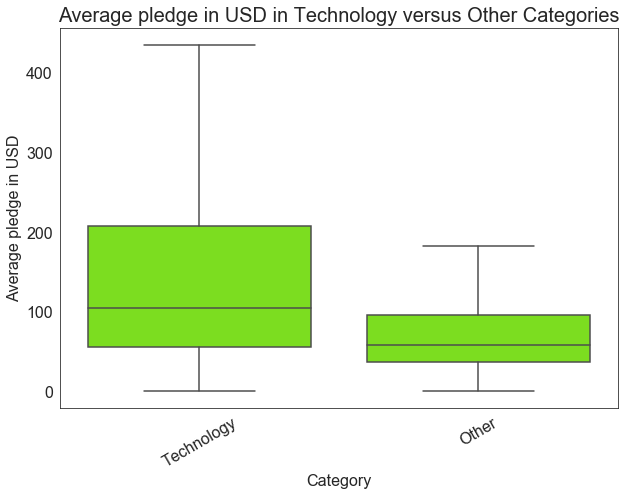

In [67]:
#Plot to estimate differences
sns.set_style("white")
successful_campaigns['tech_vs_other'] = np.where(successful_campaigns['category_parent_name']=='Technology', 'Technology', 'Other')
plt.figure(figsize=(10,7))
sns.set_style("white")
sns.boxplot(x="tech_vs_other", y="average_pledge", data=successful_campaigns, order=["Technology", "Other"], showfliers=False, color="lawngreen")
plt.title('Average pledge in USD in Technology versus Other Categories', fontsize=20)
plt.xlabel('Category', fontsize=16)
plt.ylabel('Average pledge in USD', fontsize=16)
plt.xticks(fontsize=16)
plt.xticks(rotation=30)
plt.yticks(fontsize=16);

- Number of backers (Assumption: popularity of campaign defines popularity of startup)
    - Ga je voor weinig backers met veel of veel backers met weinig -> verschil in succesful  
        -> Define average pledge per backer (see to do)  
        -> Succesful versus unsuccesful (2-sample: avg. per backer succesful versus avg. per backer unsuccesful)  
            We verwachten dat dit verschilt - gemiddelde bij succesvol hoger
Rianne  
            
- Zoja/Zonee -> define confidence intervals voor backers voor ons "start-up" plan (binnen onze categorie?)  

Elske

In [ ]:
# Sample represents the numbers of backers for succesful campaigns within the "Tech" category
succesful_campaigns = df.loc[df['state'] == 'successful']
succesful_campaigns_tech = succesful_campaigns.loc[succesful_campaigns['category_parent_name'] == 'Technology']
sample = succesful_campaigns_tech['backers_count']

#Compute degrees of freedom
df = len(sample) -1 

#Compute t-statistic, mean and standard error
t = stats.t.interval(0.95,df)[1]
x  = np.mean(sample)
se = np.std(sample) / np.sqrt(len(sample))

#Define confidence intervals
con_int = [round(num,3) for num in [x - (t * se) , x + (t * se)]]
print('With 95 % confidence, the average number of backers for a succesful campaign in Technology:', round(con_int[0]), "and", round(con_int[1]))

Bonus:
In specific categories: Pledge amount asked - Pledged (goal - converted)  
COVID impact 2020 versus 2018/2019 (less pledges than previous years - and in which categories?)  
Other differences in years   
    